In [40]:
from tensorflow import keras
from sklearn.preprocessing import StandardScaler
import numpy as np
import tensorflow as tf
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import plotly.offline as pyo
import plotly.graph_objects as go

np.random.seed(1)
tf.random.set_seed(1)

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout, RepeatVector, TimeDistributed

In [43]:
df = pd.read_csv('./stocknet/raw/AAPL.csv')

df = df[['Date', 'Open']]
df['Date'] = pd.to_datetime(df['Date'])
df['Date'].min(), df['Open'].max()

print(df)

           Date        Open
0    2012-09-04   95.108574
1    2012-09-05   96.510002
2    2012-09-06   96.167145
3    2012-09-07   96.864288
4    2012-09-10   97.207146
...         ...         ...
1253 2017-08-28  160.139999
1254 2017-08-29  160.100006
1255 2017-08-30  163.800003
1256 2017-08-31  163.639999
1257 2017-09-01  164.800003

[1258 rows x 2 columns]


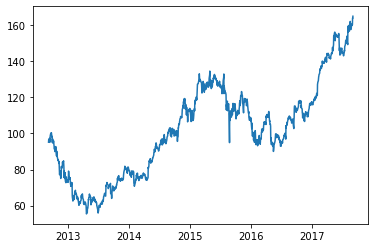

In [44]:
# fig = go.Figure()
plt.plot(df['Date'], df['Open'])
# fig.update_layout(showlegend=True, title='HDFC Bannk NSE Stock Price 1996-2020')
plt.show()

In [45]:
# train = df.loc[df['Date'] > '2010-10-01']
train = df
# train.shape, test.shape

In [46]:
train=train.replace(np.nan,0)
# test=test.replace(np.nan,0)
from sklearn.preprocessing import StandardScaler
scaler=StandardScaler()

scaler = scaler.fit(train[['Open']])

train['Open'] = scaler.transform(train[['Open']])
# test['price'] = scaler.transform(test[['price']])

<AxesSubplot:xlabel='Date', ylabel='Open'>

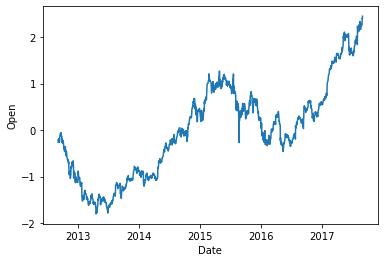

In [48]:
sns.lineplot(x=train.Date,y=train.Open)

In [49]:
TIME_STEPS=30

def create_sequences(X, y, time_steps=TIME_STEPS):
    Xs, ys = [], []
    for i in range(len(X)-time_steps):
        Xs.append(X.iloc[i:(i+time_steps)].values)
        ys.append(y.iloc[i+time_steps])
    
    return np.array(Xs), np.array(ys)

X_train, y_train = create_sequences(train[['Open']], train['Open'])
# X_test, y_test = create_sequences(test[['price']], test['price'])

print(f'Training shape: {X_train.shape}')
# print(f'Testing shape: {X_test.shape}')

Training shape: (1228, 30, 1)


In [50]:
model = Sequential()
model.add(LSTM(128, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dropout(rate=0.2))
model.add(RepeatVector(X_train.shape[1]))
model.add(LSTM(128, return_sequences=True))
model.add(Dropout(rate=0.2))
model.add(TimeDistributed(Dense(X_train.shape[2])))


In [51]:
model.compile(optimizer='adam', loss='mae')
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_4 (LSTM)                (None, 128)               66560     
_________________________________________________________________
dropout_4 (Dropout)          (None, 128)               0         
_________________________________________________________________
repeat_vector_2 (RepeatVecto (None, 30, 128)           0         
_________________________________________________________________
lstm_5 (LSTM)                (None, 30, 128)           131584    
_________________________________________________________________
dropout_5 (Dropout)          (None, 30, 128)           0         
_________________________________________________________________
time_distributed_2 (TimeDist (None, 30, 1)             129       
Total params: 198,273
Trainable params: 198,273
Non-trainable params: 0
________________________________________________

In [52]:
from tensorflow.keras.callbacks import LearningRateScheduler, ModelCheckpoint

modelpath = './anomaly_best.h5'
checkpointer = ModelCheckpoint(
    filepath=modelpath,
    monitor='val_loss',
    verbose=2,
    save_best_only=True)

history = model.fit(X_train, y_train, epochs=10, 
                    batch_size=16, 
                    validation_split=0.1,
                     shuffle=False,
                   callbacks = [checkpointer])
# callbacks=[keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, mode='min')]

Epoch 1/10
70/70 [==============================] - 3s 15ms/step - loss: 0.3325 - val_loss: 0.2073

Epoch 00001: val_loss improved from inf to 0.20734, saving model to ./anomaly_best.h5
Epoch 2/10
70/70 [==============================] - 0s 6ms/step - loss: 0.1433 - val_loss: 0.1386

Epoch 00002: val_loss improved from 0.20734 to 0.13856, saving model to ./anomaly_best.h5
Epoch 3/10
70/70 [==============================] - 0s 6ms/step - loss: 0.1227 - val_loss: 0.1649

Epoch 00003: val_loss did not improve from 0.13856
Epoch 4/10
70/70 [==============================] - 0s 7ms/step - loss: 0.1100 - val_loss: 0.2106

Epoch 00004: val_loss did not improve from 0.13856
Epoch 5/10
70/70 [==============================] - 0s 7ms/step - loss: 0.1231 - val_loss: 0.1097

Epoch 00005: val_loss improved from 0.13856 to 0.10967, saving model to ./anomaly_best.h5
Epoch 6/10
70/70 [==============================] - 0s 6ms/step - loss: 0.1838 - val_loss: 0.0978

Epoch 00006: val_loss improved from 0

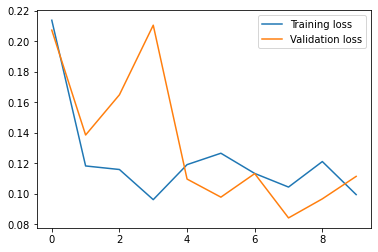

In [53]:
plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.legend()

In [39]:
# from tf.keras.models import load_model
model=tf.keras.models.load_model(modelpath)
model.evaluate(X_train, y_train)

82/82 [==============================] - 1s 3ms/step - loss: 0.0620


0.06200690194964409

Reconstruction error threshold: 0.881957631760589


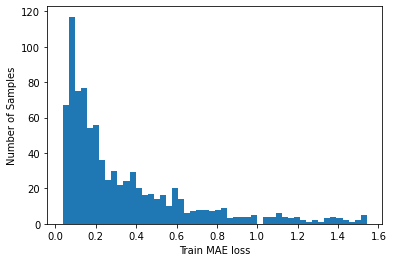

In [18]:
X_test_pred = model.predict(X_test, verbose=0)
test_mae_loss = np.mean(np.abs(X_test_pred - X_test), axis=1)

plt.hist(test_mae_loss, bins=50)
plt.xlabel('Train MAE loss')
plt.ylabel('Number of Samples');

threshold = np.mean(test_mae_loss) + np.std(test_mae_loss) *1.7
print(f'Reconstruction error threshold: {threshold}')

Text(0, 0.5, 'Number of samples')

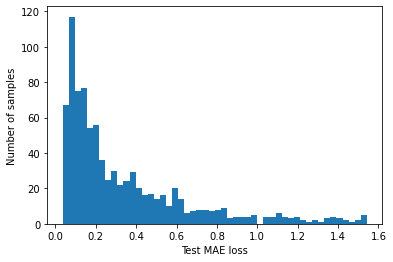

In [19]:
X_test_pred = model.predict(X_test, verbose=0)
test_mae_loss = np.mean(np.abs(X_test_pred-X_test), axis=1)

plt.hist(test_mae_loss, bins=50)
plt.xlabel('Test MAE loss')
plt.ylabel('Number of samples')

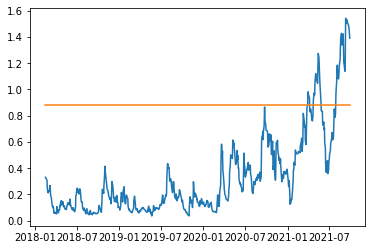

In [20]:
test_score_df = pd.DataFrame(test[TIME_STEPS:])
test_score_df['loss'] = test_mae_loss
test_score_df['threshold'] = threshold
test_score_df['anomaly'] = test_score_df['loss'] > test_score_df['threshold']
test_score_df['price'] = test[TIME_STEPS:]['price']

# fig = go.Figure()
# fig.add_trace(go.Scatter(x=test_score_df['Date'], y=test_score_df['loss'], name='Test loss'))
# fig.add_trace(go.Scatter(x=test_score_df['Date'], y=test_score_df['threshold'], name='Threshold'))
# fig.update_layout(showlegend=True, title='Test loss vs. Threshold')
# fig.show()

# fig = Figure()
plt.plot(test_score_df['Date'], test_score_df['loss'])
plt.plot(test_score_df['Date'], test_score_df['threshold'])
# plt.update_layout(showlegend=True, title='Test loss vs. Threshold')
plt.show()

In [21]:
anomalies = test_score_df.loc[test_score_df['anomaly'] == True]
anomalies.shape

(66, 5)

In [22]:
anomalies = test_score_df.loc[test_score_df['anomaly'] == True]
anomalies

,Date,price,loss,threshold,anomaly
4205,2021-03-30,5.848070,0.972852,0.881958,True
4206,2021-03-31,5.857604,0.982043,0.881958,True
4207,2021-04-01,5.886205,0.962822,0.881958,True
4208,2021-04-05,5.857604,0.936925,0.881958,True
4209,2021-04-06,6.076882,0.933146,0.881958,True
...,...,...,...,...,...
4321,2021-09-17,6.353363,1.514119,0.881958,True
4322,2021-09-23,6.296160,1.485097,0.881958,True
4323,2021-09-24,6.401032,1.474432,0.881958,True
4324,2021-09-27,6.353363,1.417291,0.881958,True


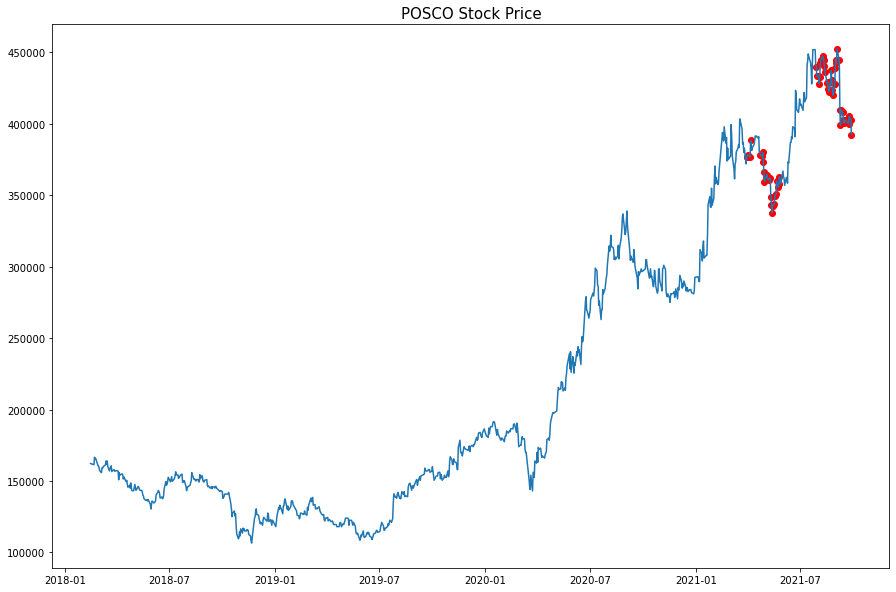

In [24]:
plt.figure(figsize=(15,10))
plt.plot(test_score_df['Date'], scaler.inverse_transform(test_score_df['price']))
plt.scatter(x=anomalies['Date'], y=scaler.inverse_transform(anomalies['price']), color='r')
# plt.plot(anomalies['Date'], scaler.inverse_transform(anomalies['price']), color='r')
# plt.update_layout(showlegend=True, title='Detected anomalies')
plt.title('POSCO Stock Price', fontsize = 15)
plt.show()

In [45]:
arr = np.array(anomalies.index)
arr

array([3474, 3475, 3488, 3494, 3495, 3496, 3497, 3549, 3550, 3551, 3552,
       3553, 3554, 3555, 3556, 3557, 3558, 3600, 3601, 3614, 3615, 3616,
       3617, 3618, 3619, 3959, 3960, 3961, 3962, 3963, 4009, 4010, 4011,
       4133, 4134, 4135, 4136, 4137, 4138, 4189, 4190, 4191, 4192, 4225,
       4226, 4227, 4232, 4233, 4234, 4235, 4250, 4251, 4252, 4253, 4254,
       4255, 4256, 4303, 4304, 4305])

In [ ]:
for i in range(len(arr)=1):
    if arr[i] + 1 == arr[i+1]:
        